In [ ]:
pip install transformers

     |████████████████████████████████| 2.1MB 4.9MB/s 
     |████████████████████████████████| 901kB 19.6MB/s 
     |████████████████████████████████| 3.3MB 24.2MB/s 


**Import libraries**


In [ ]:
import tensorflow as tf
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import nltk

**Import BERT MODEL**

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Import dataset**

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train - Sheet1.csv to train - Sheet1.csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test - Sheet1.csv to test - Sheet1.csv


In [ ]:
test = pd.read_csv('test - Sheet1.csv')
train = pd.read_csv('train - Sheet1.csv')

**Preprocessing the data**


In [ ]:
def tweet_processing(raw_tweet):
    letters_only=re.sub("[^a-zA-Z]"," ",raw_tweet)
    words=letters_only.lower().split()
    stops=set(stopwords.words("english"))
    m_w=[w for w in words if not w in stops]
    return (" ".join(m_w))

In [ ]:
for i in range(0,len(train['sentence'])):
  line = str(train['sentence'][i])
  new_line = tweet_processing(line)
  train['sentence'] = train['sentence'].replace([line], new_line)


train['label'] = train['label'].map(
                   {0:0, 2:1})
print(train)

NameError: ignored

In [ ]:
i = 0
while(i < 1000):
  line = str(train['sentence'][i])
  lab = float(train['label'][i])
  test = test.append({'sentence': line, 'label' : lab}, ignore_index=True)
  i+=1
  #train['sentence'] = train['sentence'].replace([line], NaN)

train = train.drop(range(0, 1000))
print(train)




                                                sentence  label
1000   nirahua narendramodi myogiadityanath bjp india...    0.0
1001   sunilyadv unnao yadavspriya jaha bhi dekho bjp...    1.0
1002   hayatpreghal acha hai borhi sahi laikin apne k...    NaN
1003   abdulabbasi sarfarazkhush jahil woh hota hai j...    0.0
1004   pradhan marntri ji bahot bahot subhkamnaye dhe...    1.0
...                                                  ...    ...
15125                             wow sad alika like dat    0.0
15126  rohitsharmawpg asadowaisi narendramodi shame s...    0.0
15127  prof hariom jkgrievance bijli mantri people do...    0.0
15128  amjedmbt bandisanjay bjp cpkarimnagar telangan...    0.0
15129  sunju mishra phir bjp ke leader vikas ke bare ...    0.0

[14130 rows x 2 columns]


In [ ]:
for i in range(0,len(test['sentence'])):
  line = str(test['sentence'][i])
  new_line = tweet_processing(line)
  test['sentence'] = test['sentence'].replace([line], new_line)

test['label'] = test['label'].map(
                   {0:0 , 2:1})

In [ ]:
print(test)
print(train.shape)

                                               sentence  label
0     rt uaapconfessions love looks good maddie ako ...    NaN
1     ye ye ye gonna start another june sour note uh...    NaN
2     zwfffy jgklela min lyching thakurdadu manakgup...    NaN
3     caring bohot jyada caring courier wale bsdk ke...    0.0
4     alihzaidipti sarfaraza nonesense kabhi baymani...    1.0
...                                                 ...    ...
3363  ravidubey sir apki dev movise ka kiya hua trai...    NaN
3364  abidakh diva rizvi manakgupta right mm hindu m...    NaN
3365  tinkerbell plot hi plot khurana se better koi ...    NaN
3366  kumar vinodr ranaayyub vinod ji chill man modi...    0.0
3367  lambaalka yehi toh rahul gandhi samjha rahe ki...    NaN

[3368 rows x 2 columns]
(13630, 2)


**Feature Extraction**

In [ ]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples

  train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')
  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'sentence'
LABEL_COLUMN = 'label'

In [ ]:
#print(type(train))
train.dropna(subset = ["sentence", "label"], inplace=True)
test.dropna(subset = ['sentence', 'label'], inplace=True)

train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(64).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(64)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
print(test.shape)
print(train.shape)

(1401, 2)
(8848, 2)


In [ ]:
train.to_csv('train.csv')
test.to_csv('test.csv')
from google.colab import files
files.download("train.csv")

from google.colab import files
files.download("test.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Compiling model**

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.fit(train_data, epochs=2, validation_data=validation_data)

In [ ]:
history = model.history.history

In [ ]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    trainAcc=0
    
    for ele in range(0, len(train_acc)): 
        trainAcc = trainAcc + train_acc[ele]
    
    print('Training Accuracy - ',trainAcc/len(train_acc)*100)
    
    valAcc=0
    
    for ele in range(0, len(val_acc)): 
        valAcc = valAcc + val_acc[ele]
    
    print('Validation Accuracy - ',valAcc/len(val_acc)*100)
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
for key in history.keys():
  print(key)

loss
accuracy
val_loss
val_accuracy


In [ ]:
from matplotlib import pyplot as plt


Training Accuracy -  85.96962690353394
Validation Accuracy -  73.68078231811523


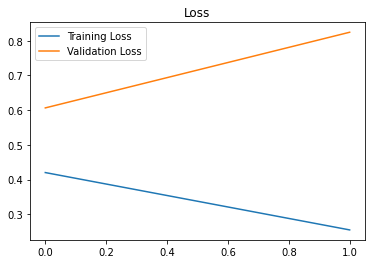

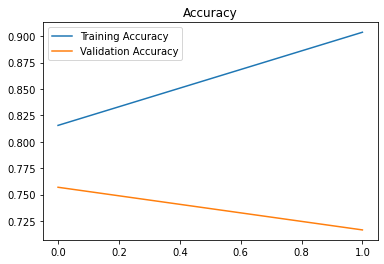

In [ ]:
plot_metrics(history)

In [ ]:
pred_sentences = ['Yeh salla minister chor hai',
                  'ghazab khelta hai yeh']

In [ ]:
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels = ['Negative','Positive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
  print(pred_sentences[i], ": \n", labels[label[i]])